In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\tanzi\Personal Projects\cold_start_project_498r\data\lambda_logs.csv")

In [3]:
df['timestamp'] = pd.to_datetime(df['Timestamp (UTC)'])

In [4]:
# Feature Engineering
df['hour'] = df['timestamp'].dt.hour

In [5]:
df['dayofweek'] = df['timestamp'].dt.dayofweek

In [6]:
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['time_bucket'] = pd.cut(df['hour'], bins=[0,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'], right=False)

In [7]:
# Add lag features for previous 3 invocations
for i in range(1, 4):  # You can change 4 to any K+1
    df[f'prev_delay_{i}'] = df['Delay (s)'].shift(i)
    df[f'prev_cold_{i}'] = df['Cold_Start'].shift(i)

df.dropna(inplace=True)

In [8]:
# Rolling Features
df['rolling_avg_delay'] = df['Delay (s)'].rolling(window=3).mean()
df['rolling_cold_rate'] = df['Cold_Start'].rolling(window=3).mean() 

In [9]:
# Anomaly Detection with Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly_flag'] = (iso.fit_predict(df[['Delay (s)']].fillna(0)) == -1).astype(int)

In [10]:
# Time Since Last Cold Start
df['last_cold_time'] = df['timestamp'].where(df['Cold_Start'] == 1).ffill()
df['last_cold_time'] = pd.to_datetime(df['last_cold_time'])

In [11]:
df['time_since_last_cold'] = (df['timestamp'] - df['last_cold_time']).dt.total_seconds()

In [12]:
# Cold Start Probability Estimate
df['cold_start_prob_est'] = df['Delay (s)'].apply(lambda x: min(x / 300, 1))

In [13]:
# One-hot encode time bucket
df = pd.get_dummies(df, columns=['time_bucket'], prefix='bucket')

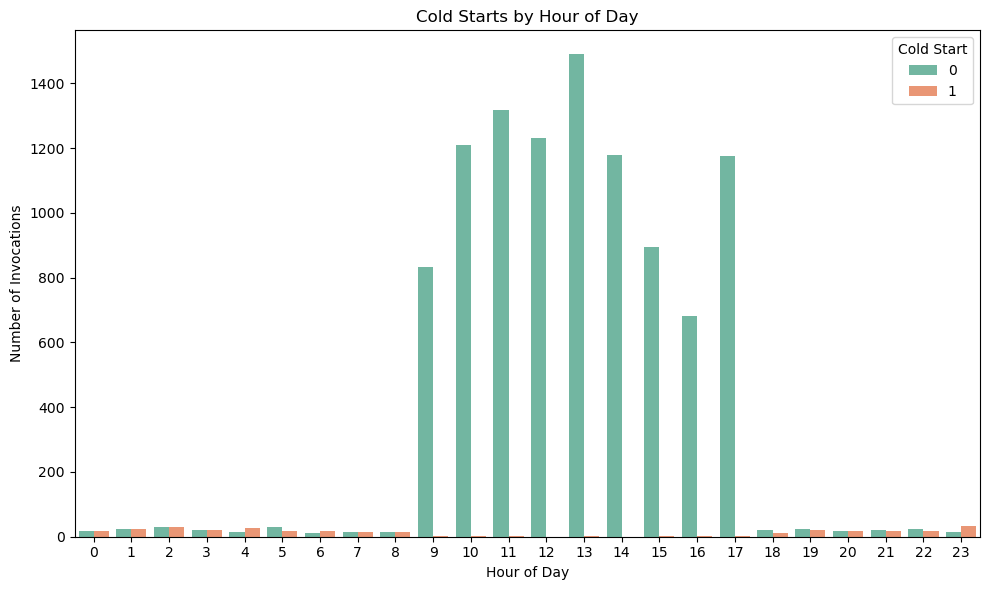

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour', hue='Cold_Start', palette='Set2')
plt.title('Cold Starts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Invocations')
plt.legend(title='Cold Start')
plt.tight_layout()
plt.savefig("fig_cold_starts_by_hour.png")
plt.show()


In [15]:
# Save clean file
df.to_csv(r"C:\Users\tanzi\Personal Projects\cold_start_project_498r\data\clean_data.csv", index=False)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\tanzi\\Personal Projects\\cold_start_project_498r\\data\\clean_data.csv'

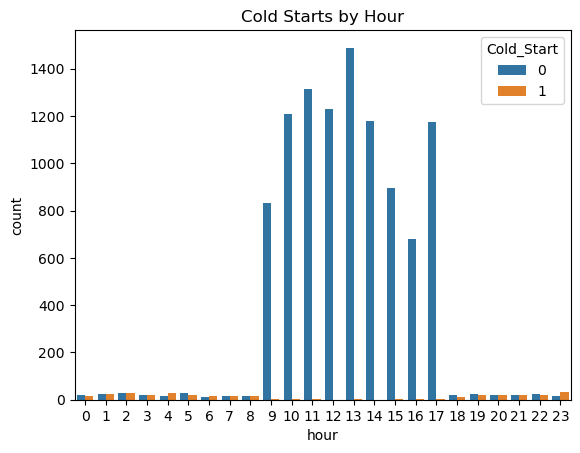

In [ ]:
# Plotting
sns.countplot(data=df, x='hour', hue='Cold_Start')
plt.title("Cold Starts by Hour")
plt.show()

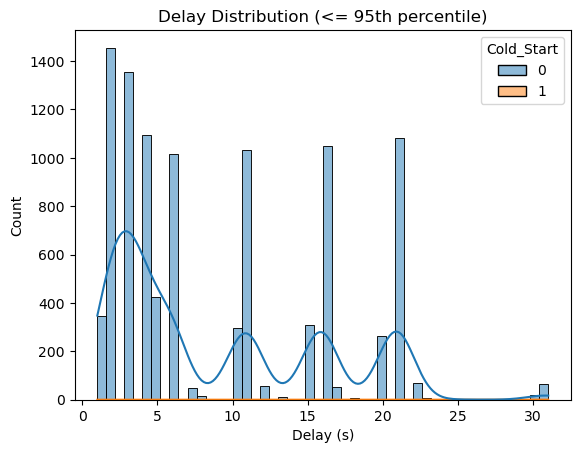

In [ ]:
p95 = df['Delay (s)'].quantile(0.95)
sns.histplot(data=df[df['Delay (s)'] <= p95], x='Delay (s)', hue='Cold_Start', bins=50, kde=True)
plt.title("Delay Distribution (<= 95th percentile)")
plt.savefig("Delay Distribution.png", dpi=300)
plt.show()

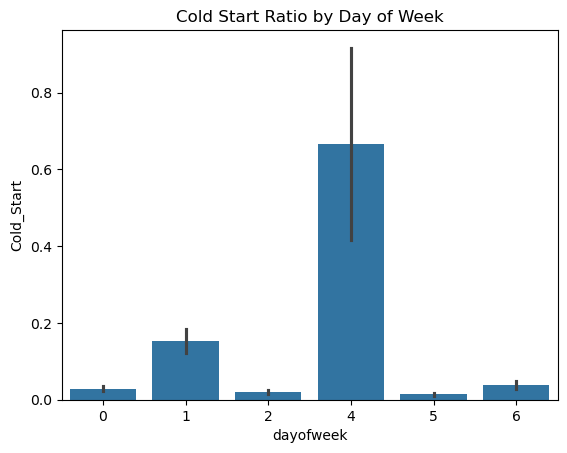

In [ ]:
# Additional Visuals
sns.barplot(x='dayofweek', y='Cold_Start', data=df)
plt.title("Cold Start Ratio by Day of Week")
plt.show()